In [1]:
from vit_jax import models
import jax
import jax.numpy as jnp
from PIL import Image
import numpy as np
import glob
import os

2023-08-19 11:29:08.053165: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
model_name = 'LiT-B16B'
lit_model = models.get_model(model_name)
lit_variables = lit_model.load_variables()
tokenizer = lit_model.get_tokenizer()
image_preprocessing = lit_model.get_image_preprocessing()
pp = lit_model.get_pp()


# Convert to npy file

In [31]:
import googletrans
import translate

class Translation:
    def __init__(self, from_lang='vi', to_lang='en', mode='google'):
        # The class Translation is a wrapper for the two translation libraries, googletrans and translate. 
        self.__mode = mode
        self.__from_lang = from_lang
        self.__to_lang = to_lang

        if mode in 'googletrans':
            self.translator = googletrans.Translator()
        elif mode in 'translate':
            self.translator = translate.Translator(from_lang=from_lang,to_lang=to_lang)

    def preprocessing(self, text):
        """
        It takes a string as input, and returns a string with all the letters in lowercase
        :param text: The text to be processed
        :return: The text is being returned in lowercase.
        """
        return text.lower()

    def __call__(self, text):
        """
        The function takes in a text and preprocesses it before translation
        :param text: The text to be translated
        :return: The translated text.
        """
        text = self.preprocessing(text)
        return self.translator.translate(text) if self.__mode in 'translate' \
                else self.translator.translate(text, dest=self.__to_lang).text
    
translate = Translation()

In [32]:
import os 
import glob
import numpy as np


os.system('TF_CPP_MIN_LOG_LEVEL=0')

root_path = "data/OCR_ASR/"
txt_paths = glob.glob('data/OCR_ASR/Content_txt/*/*.txt')
txt_paths = sorted(txt_paths)

for txt_path in txt_paths:
    bath_name = "Embed_npy_LIT"
    video_name = txt_path.split("/")[-2]
    
    des_path = f'{root_path}/{bath_name}/{video_name}'
    os.makedirs(des_path, exist_ok=True)

    with open(txt_path, "rb") as f:
        line = f.read()

    line = line.decode("utf-8")
    text = [line, ]
    if text[0] == '':
        print(f'Skip: {txt_path}')
        continue
    else:
        text = [translate(text[0]),]
        tokens = tokenizer([text])
        _, text_embeddings, _ = lit_model.apply(lit_variables, tokens=tokens)
        name_npy = txt_path.split('/')[-1].replace('.txt', '')
        outfile = f'{des_path}/{name_npy}.npy'
        np.save(outfile, text_embeddings)

Skip: data/OCR_ASR/Content_txt/C00_V0000/C00_V0000_1091_1147.txt
Skip: data/OCR_ASR/Content_txt/C00_V0000/C00_V0000_1148_1559.txt
Skip: data/OCR_ASR/Content_txt/C00_V0000/C00_V0000_160_202.txt
Skip: data/OCR_ASR/Content_txt/C00_V0000/C00_V0000_26586_26590.txt
Skip: data/OCR_ASR/Content_txt/C00_V0000/C00_V0000_27652_28028.txt
Skip: data/OCR_ASR/Content_txt/C00_V0000/C00_V0000_28029_28131.txt
Skip: data/OCR_ASR/Content_txt/C00_V0000/C00_V0000_524_576.txt
Skip: data/OCR_ASR/Content_txt/C00_V0000/C00_V0000_7137_7208.txt
Skip: data/OCR_ASR/Content_txt/C00_V0000/C00_V0000_9150_9174.txt
Skip: data/OCR_ASR/Content_txt/C00_V0001/C00_V0001_1155_1546.txt
Skip: data/OCR_ASR/Content_txt/C00_V0001/C00_V0001_11568_11574.txt
Skip: data/OCR_ASR/Content_txt/C00_V0001/C00_V0001_13535_13563.txt
Skip: data/OCR_ASR/Content_txt/C00_V0001/C00_V0001_171_225.txt
Skip: data/OCR_ASR/Content_txt/C00_V0001/C00_V0001_17812_17821.txt
Skip: data/OCR_ASR/Content_txt/C00_V0001/C00_V0001_527_581.txt
Skip: data/OCR_ASR/Co

# Create bin file 

In [4]:
import numpy as np
import faiss
import glob
import json
import matplotlib.pyplot as plt
import os
import math
import torch
import pandas as pd
from tqdm import tqdm




import googletrans
import translate

class Translation:
    def __init__(self, from_lang='vi', to_lang='en', mode='google'):
        # The class Translation is a wrapper for the two translation libraries, googletrans and translate. 
        self.__mode = mode
        self.__from_lang = from_lang
        self.__to_lang = to_lang

        if mode in 'googletrans':
            self.translator = googletrans.Translator()
        elif mode in 'translate':
            self.translator = translate.Translator(from_lang=from_lang,to_lang=to_lang)

    def preprocessing(self, text):
        """
        It takes a string as input, and returns a string with all the letters in lowercase
        :param text: The text to be processed
        :return: The text is being returned in lowercase.
        """
        return text.lower()

    def __call__(self, text):
        """
        The function takes in a text and preprocesses it before translation
        :param text: The text to be translated
        :return: The translated text.
        """
        text = self.preprocessing(text)
        return self.translator.translate(text) if self.__mode in 'translate' \
                else self.translator.translate(text, dest=self.__to_lang).text
    

class MyFaiss:
    def __init__(self, root_database: str, bin_file: str, json_path: str):
        self.index = self.load_bin_file(bin_file)
        self.id2img_fps = self.load_json_file(json_path)
        self.translater = Translation()
        self.__device = "cuda" if torch.cuda.is_available() else "cpu"
        # self.model, preprocess = clip.load("ViT-B/16", device=self.__device)

    def load_bin_file(self, bin_file: str):
        return faiss.read_index(bin_file)
    
    def load_json_file(self, json_bath: str):
        with open(json_bath, "r") as f:
            js = json.loads(f.read())

        return {int(k): v for k, v in js.items()}
    def show_images(self, image_paths):
        fig = plt.figure(figsize=(15, 10))
        columns = int(math.sqrt(len(image_paths)))
        rows = int(np.ceil(len(image_paths)/columns))

        for i in range(1, columns*rows +1):
            img = plt.imread(image_paths[i - 1])
            ax = fig.add_subplot(rows, columns, i)
            ax.set_title('/'.join(image_paths[i - 1].split('/')[-3:]))

            plt.imshow(img)
            plt.axis("off")

        plt.show()


In [5]:
from vit_jax import models
import jax
import jax.numpy as jnp
from PIL import Image
import numpy as np
import glob
import os

class BERTSearch(MyFaiss):
    def __init__(self, dict_bert_search = 'data/OCR_ASR/keyframes_id_bert.json', bin_file = 'data/OCR_ASR/faiss_beart_LIT.bin', mode = 'write' ):
        if mode == 'search':
            model_name = 'LiT-B16B'
            self.model = models.get_model(model_name)
            self.index =  super().load_bin_file(bin_file)
            self.id2img_fps = super().load_json_file(dict_bert_search)
            self.translate = Translation()
            
        else:
            pass
    def create_files(self, des_json: str, dict_support_model:str, des_bin: str):
        count = 0
        self.infos = []
        id2img_fps = super().load_json_file(dict_support_model)
        npy_paths = sorted(glob.glob("data/OCR_ASR/Embed_npy_LIT/*/*.npy"))
        index = faiss.IndexFlatL2(768)

        for npy_path in tqdm(npy_paths):
            need_path = npy_path.split('/')[-1].replace('.npy','')
            for id, values in id2img_fps.items():
                image_path = values['image_path']
                list_shot_id = values['list_shot_id']
                start, end = int(list_shot_id[0]), int(list_shot_id[-1])
                check_path = image_path.split('/')[-2] + f"_{start}_{end}"
                # print("Need_path",need_path)
                # print("Check_path",check_path)
                # break
                if need_path == check_path:
                    # print("Satisfy the condition")
                    info = {
                        "video_path": '/'.join(image_path.split('/')[:-1]),
                        "list_shot_id": list_shot_id
                    }
                    self.infos.append(info)

                    try:
                        feat = np.load(npy_path)

                    except:
                        print(npy_path)

                    feat = feat.astype(np.float32).reshape(1,-1)
                    index.add(feat)
                    id2img_fps.pop(id)
                    count += 1
                    break

        results = dict(enumerate(self.infos)) 

        ##### SAVE JSON FILE #####
        with open(des_json, 'w') as f:
            f.write(json.dumps(results))

        faiss.write_index(index, des_bin)

        print(f'Saved {des_json}')
        print(f"Number of Index: {count}")
        print(f'Saved {des_bin}')

    def bert_search(self, text, k):
        os.system('TF_CPP_MIN_LOG_LEVEL=0')
        model_name = 'LiT-B16B'
        lit_model = models.get_model(model_name)
        tokenizer = lit_model.get_tokenizer()
        lit_variables = lit_model.load_variables()
        text = self.translate(text)
        tokens = tokenizer([text])
        _, text_features, _ = lit_model.apply(lit_variables, tokens=tokens)

        scores, idx_image = self.index.search(np.array(text_features), k=k)
        idx_image = idx_image.flatten()

        infos_query = list(map(self.id2img_fps.get, list(idx_image)))
        print(infos_query)
        # image_paths = [info['video_path'] for info in infos_query]
        image_paths =  [os.path.join(info['video_path'],f"{info['list_shot_id'][0]}.jpg") for info in infos_query]
        return scores, idx_image, infos_query, image_paths

In [8]:
create_file = BERTSearch()
create_file.create_files(des_json='data/OCR_ASR/keyframes_id_bert.json', dict_support_model='data/faiss_merge_files/keyframes_id.json', des_bin='data/OCR_ASR/faiss_bert_ASR_LIT.bin')

  0%|          | 0/473 [00:00<?, ?it/s]

100%|██████████| 473/473 [00:00<00:00, 528.92it/s]

Saved data/OCR_ASR/keyframes_id_bert.json
Number of Index: 473
Saved data/OCR_ASR/faiss_bert_ASR_LIT.bin



⚠️ Reusing local copy: LiT-B16B.npz
[{'video_path': 'data/KeyFramesC00_V00/C00_V0000', 'list_shot_id': ['002673', '002681', '002689', '002697', '002706']}, {'video_path': 'data/KeyFramesC00_V00/C00_V0001', 'list_shot_id': ['014500', '014510', '014520', '014521', '014532', '014543']}, {'video_path': 'data/KeyFramesC00_V00/C00_V0001', 'list_shot_id': ['023864', '023934', '024004', '024037', '024074']}, {'video_path': 'data/KeyFramesC00_V00/C00_V0001', 'list_shot_id': ['004160', '004170', '004180', '004190', '004200']}, {'video_path': 'data/KeyFramesC00_V00/C00_V0000', 'list_shot_id': ['002150', '002280', '002325', '002411', '002500', '002541']}, {'video_path': 'data/KeyFramesC00_V00/C00_V0001', 'list_shot_id': ['002379', '002391', '002404', '002417']}, {'video_path': 'data/KeyFramesC00_V00/C00_V0001', 'list_shot_id': ['001778', '001784', '001790', '001796']}, {'video_path': 'data/KeyFramesC00_V00/C00_V0000', 'list_shot_id': ['026886', '026898', '026911', '026924']}, {'video_path': 'data

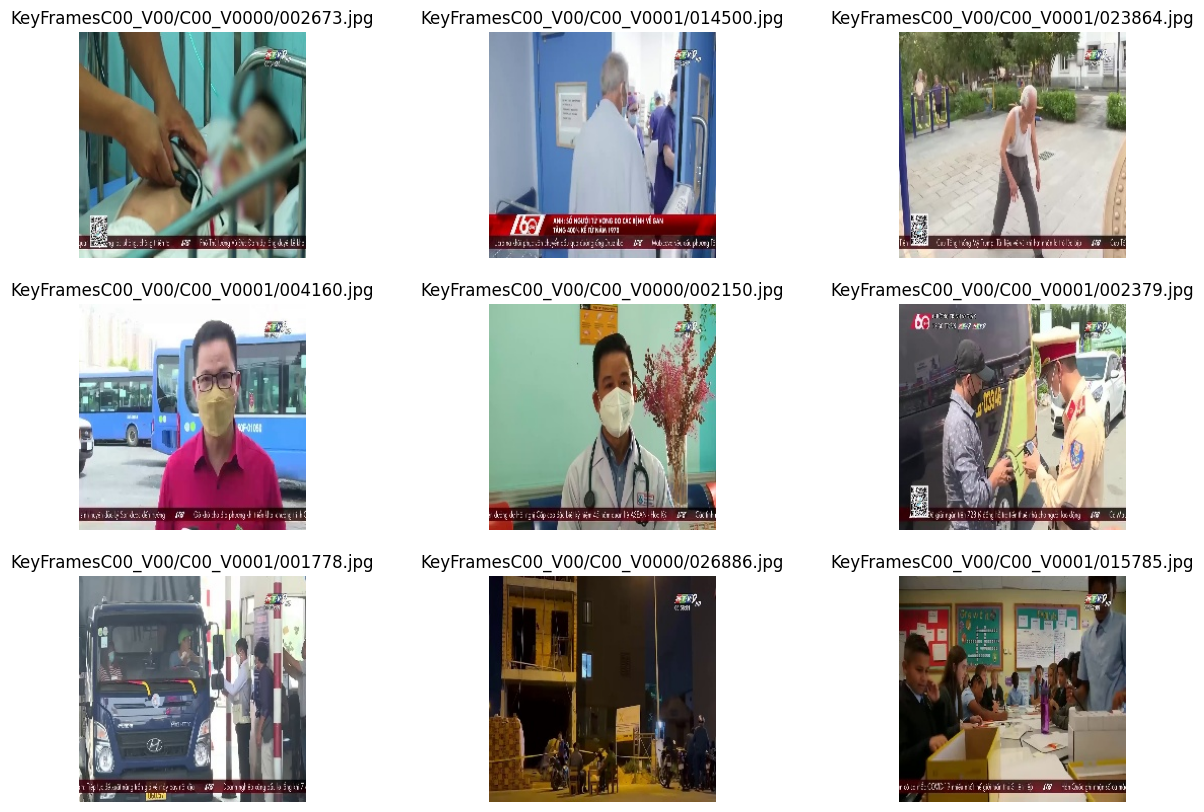

In [13]:
mybert = BERTSearch(dict_bert_search='data/OCR_ASR/keyframes_id_bert.json', bin_file='data/OCR_ASR/faiss_bert_ASR_LIT.bin', mode='search')

text = "nguyên nhân do phụ huynh chủ quan"

scores, idx_image, infos_query, image_paths = mybert.bert_search(text, k=9)
mybert.show_images(image_paths)


⚠️ Reusing local copy: LiT-B16B.npz
Text translation:  The Ministry of Health recommends not using methanol
Time inference of search: 0.7778563499450684


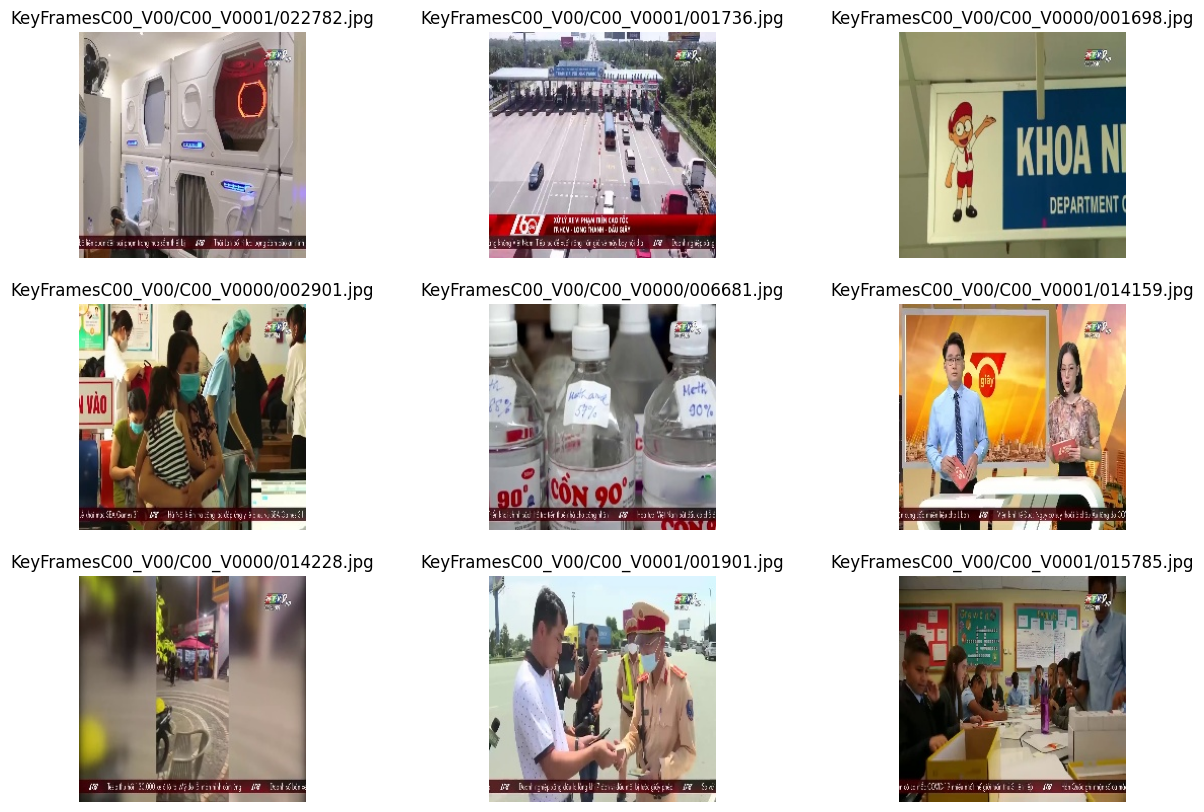

In [3]:
from utils.translate_processing import Translation
from vit_jax import models
import time
import os
import json
import matplotlib.pyplot as plt
from langdetect import detect
import numpy as np
import faiss
import math


def time_complexity(func):
    def wrapper(*args, **kwargs):
        start = time.time()
        results = func(*args, **kwargs)
        print('Time inference of {}: {}'.format(args[0].mode, time.time() - start))
        return results
    return wrapper


class FaissSearch(Translation):
    def __init__(self, dict_bert_search = 'data/OCR_ASR/keyframes_id_bert.json', bin_file = 'data/OCR_ASR/faiss_beart_LIT.bin', mode = 'write', model = "lit"):
        self.mode = mode
        self.index = self.load_bin_file(bin_file)
        self.id2img_fps = self.load_json_file(dict_bert_search)
        if model == "lit":
            os.system('TF_CPP_MIN_LOG_LEVEL=0')
            self.lit_model = models.get_model("LiT-B16B")
            self.lit_var = self.lit_model.load_variables()
            self.tokenizer = self.lit_model.get_tokenizer()
            self.translate = Translation()
        else:
            pass
    def load_bin_file(self, bin_file: str):
        return faiss.read_index(bin_file)
    def load_json_file(self, json_bath: str):
        with open(json_bath, "r") as f:
            js = json.loads(f.read())
        return {int(k): v for k, v in js.items()}
    
    def show_images(self, image_paths):
        fig = plt.figure(figsize=(15, 10))
        columns = int(math.sqrt(len(image_paths)))
        rows = int(np.ceil(len(image_paths)/columns))

        for i in range(1, columns*rows +1):
            img = plt.imread(image_paths[i - 1])
            ax = fig.add_subplot(rows, columns, i)
            ax.set_title('/'.join(image_paths[i - 1].split('/')[-3:]))

            plt.imshow(img)
            plt.axis("off")

        plt.show()

    @time_complexity
    def text_search(self, text, k):
        if detect(text) == "vi":
            text = self.translate(text)
            print("Text translation: ", text)
            tokens = self.tokenizer([text])
            _, text_features, _ = self.lit_model.apply(self.lit_var, tokens=tokens)
            scores, idx_image = self.index.search(np.array(text_features), k=k)
            idx_image = idx_image.flatten()
            infos_query = list(map(self.id2img_fps.get, list(idx_image)))
            image_paths =  [os.path.join(info['video_path'],f"{info['list_shot_id'][0]}.jpg") for info in infos_query]
            return scores, idx_image, infos_query, image_paths


def main():
    faiss_search = FaissSearch(dict_bert_search='data/OCR_ASR/keyframes_id_bert.json', bin_file='data/OCR_ASR/faiss_bert_ASR_LIT.bin', mode='search')
    text = "bộ y tế khuyến cáo không dùng methanol"
    scores, idx_image, infos_query, image_paths = faiss_search.text_search(text, k=9)
    faiss_search.show_images(image_paths)

    
if __name__ == "__main__":
    main()
